# Siamese Network on template ligand-docking dataset

In [1]:
!nvidia-smi

Thu Feb  3 12:26:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8    14W / 240W |    685MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [5]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [6]:
path = Path('../dataset/oldsmiledata')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/valid_balanced_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [8]:
#IMAGES = path/'mol_images'/'all'
train = pd.read_csv(path/f'train_balanced_{dataset}.csv')
valid = pd.read_csv(path/f'valid_balanced_{dataset}.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19625 entries, 0 to 19624
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      19625 non-null  int64  
 1   template                        19625 non-null  object 
 2   docked                          19625 non-null  object 
 3   rmsd                            19625 non-null  float64
 4   uniprot_id                      19625 non-null  object 
 5   smiles_template                 19625 non-null  object 
 6   smiles_docked                   19625 non-null  object 
 7   mcs_smartsString                19625 non-null  object 
 8   template_HeavyAtomCount         19625 non-null  int64  
 9   template_NHOHCount              19625 non-null  int64  
 10  template_NOCount                19625 non-null  int64  
 11  template_RingCount              19625 non-null  int64  
 12  template_NumHAcceptors          

In [10]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5323 entries, 0 to 5322
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      5323 non-null   int64  
 1   template                        5323 non-null   object 
 2   docked                          5323 non-null   object 
 3   rmsd                            5323 non-null   float64
 4   uniprot_id                      5323 non-null   object 
 5   smiles_template                 5323 non-null   object 
 6   smiles_docked                   5323 non-null   object 
 7   mcs_smartsString                5323 non-null   object 
 8   template_HeavyAtomCount         5323 non-null   int64  
 9   template_NHOHCount              5323 non-null   int64  
 10  template_NOCount                5323 non-null   int64  
 11  template_RingCount              5323 non-null   int64  
 12  template_NumHAcceptors          53

In [11]:
train.head()

,Unnamed: 0,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,...,mcs_docked_NumHDonors,mcs_template_NumRotatableBonds,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,is_valid
0,1,2JH5_895,1C5O_BAM,3.209,P00734,C[C@@H](C(=O)N1CCOCC1)N1CC[C@H](NS(=O)(=O)/C=C...,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-[#6]:,-[#6]:,-[#6]",28,1,...,1,0,1,0.050847,0.059829,1.165959,3,-1.491525,-2.401709,False
1,2,5Y12_8JX,1TOW_CRZ,1.769,P15090,COc1ccc(S(=O)(=O)NCCCCC(=O)O)c2ccccc12,O=C(O)CCCn1c2ccccc2c2ccccc21,[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1:[#6]:[#6]:[#6...,23,2,...,0,0,0,0.324561,0.324561,0.570414,1,1.245614,0.245614,False
2,4,2W26_RIV,2Y80_439,7.217,P00742,O=C(NC[C@H]1CN(c2ccc(N3CCOCC3=O)cc2)C(=O)O1)c1...,CN(C)[C@@H]1CCc2cc(N3CC[C@H](NS(=O)(=O)c4ccc5c...,[#7]-[#6]-[#6]-[#6]-[#7](-[#6]1:[#6]:[#6]:[#6]...,29,1,...,1,3,2,0.187166,0.283237,1.976439,3,-0.128342,-0.167630,False
3,5,1C1U_BAI,2C8W_C7M,4.928,P00734,N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1,COc1ccc(S(=O)(=O)NC[C@@H](O)[C@H](Cc2ccccc2)[N...,"[#6]-,:[#6]:[#6]:[#6]:[#6](:,-[#7]:,-[#6]):[#6...",22,5,...,0,1,2,0.139037,0.157609,1.594933,3,-0.609626,-1.423913,False
4,6,5AFY_WCE,3SV2_P05,7.608,P00734,NC(=O)c1cccc(Cl)c1,N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCc1ccncc1,"[#7]-[#6](=[#8])-[#6]:,-[#6]:,-[#6]:[#6]:[#6]:...",10,2,...,0,1,4,0.116071,0.157407,2.029200,3,-0.839286,-1.425926,False


# Preprocessing building ImageDataGenerator

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

2022-02-03 12:26:58.915613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Splitting the data into train and validation sets

In [13]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19625 entries, 0 to 19624
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      19625 non-null  int64  
 1   template                        19625 non-null  object 
 2   docked                          19625 non-null  object 
 3   rmsd                            19625 non-null  float64
 4   uniprot_id                      19625 non-null  object 
 5   smiles_template                 19625 non-null  object 
 6   smiles_docked                   19625 non-null  object 
 7   mcs_smartsString                19625 non-null  object 
 8   template_HeavyAtomCount         19625 non-null  int64  
 9   template_NHOHCount              19625 non-null  int64  
 10  template_NOCount                19625 non-null  int64  
 11  template_RingCount              19625 non-null  int64  
 12  template_NumHAcceptors          

In [14]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['is_valid'] = True
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5323 entries, 0 to 5322
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      5323 non-null   int64  
 1   template                        5323 non-null   object 
 2   docked                          5323 non-null   object 
 3   rmsd                            5323 non-null   float64
 4   uniprot_id                      5323 non-null   object 
 5   smiles_template                 5323 non-null   object 
 6   smiles_docked                   5323 non-null   object 
 7   mcs_smartsString                5323 non-null   object 
 8   template_HeavyAtomCount         5323 non-null   int64  
 9   template_NHOHCount              5323 non-null   int64  
 10  template_NOCount                5323 non-null   int64  
 11  template_RingCount              5323 non-null   int64  
 12  template_NumHAcceptors          53

In [15]:
# image size 224,224
target_shape=(224, 224)

In [16]:
IMAGES = '../dataset/oldsmiledata/mol_images/all/'

In [17]:
def preprocess_image(filename):
    img_str = tf.io.read_file(IMAGES + filename)
    image = tf.image.decode_png(img_str, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    #image = tf.transpose(image)
    return image

In [18]:
preprocess_image(train.img_temp[0]).shape

2022-02-03 12:26:59.684269: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-03 12:26:59.684850: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-03 12:26:59.743442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-03 12:26:59.745504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2022-02-03 12:26:59.745624: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-03 12:26:59.750158: I tensorflow/stream_executor/platform/default/

TensorShape([224, 224, 3])

In [19]:
def preprocess_triplets(template, docked, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(template), preprocess_image(docked), preprocess_image(negative))
    

In [20]:
def preprocess_triplets_2(tup, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (preprocess_image(tup[0]),
        preprocess_image(tup[1]),
        preprocess_image(negative))

In [21]:
image = preprocess_image('/4A7I_A7I.png')
image.shape

TensorShape([224, 224, 3])

In [22]:
train_template_images = [r.img_temp for i, r in train.iterrows()]

In [23]:
train_docked_images = [r.img_docked for i, r in train.iterrows()]

In [24]:
len(train_template_images), len(train_docked_images)

(19625, 19625)

In [25]:
valid_template_images = [r.img_temp for i, r in valid.iterrows()]
valid_docked_images = [r.img_docked for i, r in valid.iterrows()]

In [26]:
negative_images = train_template_images + train_docked_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [27]:
val_negative_images = valid_template_images + valid_docked_images
np.random.RandomState(seed=32).shuffle(negative_images)

val_negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
val_negative_dataset = negative_dataset.shuffle(buffer_size=4096)

In [28]:
image_count = len(train_template_images) + len(valid_template_images)
image_count

24948

In [29]:
template_dataset = tf.data.Dataset.from_tensor_slices(train_template_images)
docked_dataset = tf.data.Dataset.from_tensor_slices(train_docked_images)

In [30]:
val_template_dataset = tf.data.Dataset.from_tensor_slices(valid_template_images)
val_docked_dataset = tf.data.Dataset.from_tensor_slices(valid_docked_images)

In [31]:
y_train = train['log_RMSD']
y_train = tf.data.Dataset.from_tensor_slices(list(y_train))


In [32]:
y_valid = valid['log_RMSD']
y_valid = tf.data.Dataset.from_tensor_slices(list(y_train))

### Create the train and validation datasets

In [33]:
train_dataset = tf.data.Dataset.zip((docked_dataset, template_dataset,  negative_dataset))
#train_dataset = tf.data.Dataset.zip((train_dataset, negative_dataset))
valid_dataset = tf.data.Dataset.zip((val_docked_dataset, val_template_dataset, val_negative_dataset))
#valid_dataset = tf.data.Dataset.zip((valid_dataset, val_negative_dataset))
train_dataset, valid_dataset

(<ZipDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.string)>,
 <ZipDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.string)>)

In [34]:
train_dataset = train_dataset.take(round(image_count * 1))
train_dataset

<TakeDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.string)>

In [35]:
train_dataset = train_dataset.map(preprocess_triplets)
val_dataset = valid_dataset.map(preprocess_triplets)
train_dataset, val_dataset

(<MapDataset shapes: ((224, 224, 3), (224, 224, 3), (224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>,
 <MapDataset shapes: ((224, 224, 3), (224, 224, 3), (224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>)

In [36]:
train_dl = train_dataset.batch(32, drop_remainder=True)
train_dl = train_dl.prefetch(8)
train_dl

<PrefetchDataset shapes: ((32, 224, 224, 3), (32, 224, 224, 3), (32, 224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>

In [37]:
val_dl = val_dataset.batch(32, drop_remainder=True)
val_dl = val_dl.prefetch(8)
val_dl

<PrefetchDataset shapes: ((32, 224, 224, 3), (32, 224, 224, 3), (32, 224, 224, 3)), types: (tf.float32, tf.float32, tf.float32)>

## Anchor, positive and the distance between them computed by the distance layer

2022-02-03 12:27:03.422704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-03 12:27:03.447658: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3999980000 Hz


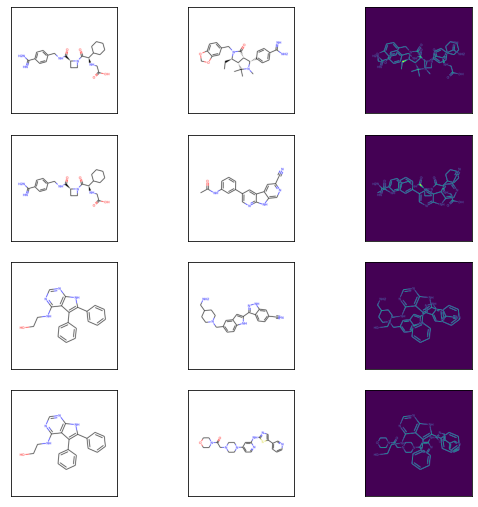

In [38]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(4, 3)
    for i in range(0, 4, 2):
        show(axs[i, 0], anchor[i])
        show(axs[i + 1, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i + 1, 1], negative[i])
        ap_distance = tf.reduce_sum(tf.square(anchor[i] - positive[i]), -1)
        an_distance = tf.reduce_sum(tf.square(anchor[i] - negative[i]), -1)
        show(axs[i, 2], ap_distance)
        show(axs[i + 1, 2], an_distance)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss, 0.0)
    


visualize(*list(val_dl.take(1).as_numpy_iterator())[0])

## Anchor, positive and the negative image

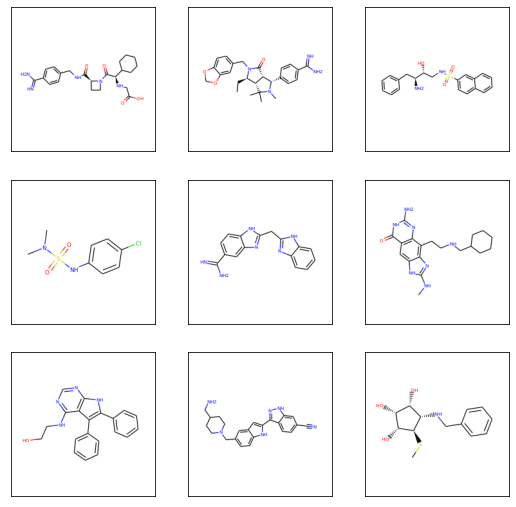

In [39]:
def visualize2(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize2(*list(val_dl.take(1).as_numpy_iterator())[0])

In [97]:
def visualize_positive(anchor, positive):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(1, 2))

    axs = fig.subplots(1, 2)
    show(axs[0, 0], anchor)
    show(axs[0, 1], positive)

# Siamese network with distance layer and triplet loss

In [40]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape +  (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


In [41]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
positive (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
negative (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 224, 224, 3)  0           anchor[0][0]                     
______________________________________________________________________________________________

### Triplet loss defined as: 

$$\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}^{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}^{2}+\alpha ,0\right)$$

In [42]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        self.rmse_tracker = metrics.RootMeanSquaredError(name="rmse")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        ap_distance, an_distance = self.siamese_network(data)
        er
        # Let's update and return the loss metric and rmse metric.
        self.loss_tracker.update_state(loss)
        # RMSE (Euclidean distance) between anchor and positive image
        self.rmse_tracker.update_state(0.0, ap_distance)
        return {"loss": self.loss_tracker.result(), 'rmse': self.rmse_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.rmse_tracker]


### Choose optimizer and train model

In [43]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), metrics=[metrics.RootMeanSquaredError(name='rmse')])

In [44]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [45]:
model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=5)

Epoch 1/5


2022-02-03 12:27:10.704775: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-03 12:27:10.924497: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-03 12:27:11.485802: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-02-03 12:27:11.521204: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-02-03 12:27:30.215389: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-03 12:2

KeyboardInterrupt: 

In [ ]:
model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=5)

In [ ]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pd.DataFrame(model.history).plot(figsize=(8,5))
print("Loss, validation loss and RMSE")
plt.show()

### Previous results: 
### loss: 0.315 - val_loss: 0.219 - RMSE: 0.7255 for 1 epoch 
### loss: 0.115 - val_loss: 0.123 - RMSE: 0.678 for 5 epochs 
### loss: 0. - val_loss. 0. - RMSE:  for 10 epochs 

## Inspecting what the network has learned

In [ ]:
sample = next(iter(val_dl))
visualize2(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())


In [208]:
from mpl_toolkits.mplot3d import Axes3D
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pickle
#import sklearn, pandas as pd, seaborn as sn
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Load models
#model = embedding
siamese_model = siamese_model

names = next(iter(val_dl))

anchor, positive, negative = names
anchor = tf.reshape(anchor[0], (1, 224, 224, 3))
positive = tf.reshape(positive[0], (1, 224, 224, 3))
negative = tf.reshape(negative[0], (1, 224, 224, 3))


test_im = []
test_im.append(anchor)
test_im.append(positive)
test_im.append(negative)

print(test_im[0].shape)
_, r,c,_ = test_im[0].shape
print(test_im[0].shape)
test_im = np.array(test_im)
test_im = test_im.reshape((len(test_im), r,c,3))

test_im = 1 - test_im/255

# Predict
pred = model.predict([anchor, positive, negative])

print(pred)

num = int(pred.shape[0]/3)
colors = ['red', 'blue', 'green'] # set colors of target labels

# Set target labels
y = [colors[0] for i in range(num)]
y += [colors[1] for i in range(num)]
y += [colors[2] for i in range(num)]

feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]

# Plot 3d scatter plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(feat1, feat2, feat3, c=y, marker='.')
plt.show()

(1, 224, 224, 3)
(1, 224, 224, 3)
(array([0.42027527], dtype=float32), array([4.7686567], dtype=float32))


AttributeError: 'tuple' object has no attribute 'shape'

# Parameter optimization 

## Adam vs SGD

In [46]:
def create_embedding(dropout = None):
    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape +  (3,), include_top=False
    )

    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    if dropout != None: 
        layer = layers.Dropout(dropout)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
    return embedding

In [47]:
def create_siamese_net(embedding):
    anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
    positive_input = layers.Input(name="positive", shape=target_shape + (3,))
    negative_input = layers.Input(name="negative", shape=target_shape + (3,))

    distances = DistanceLayer()(
        embedding(resnet.preprocess_input(anchor_input)),
        embedding(resnet.preprocess_input(positive_input)),
        embedding(resnet.preprocess_input(negative_input)),
    )

    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input], outputs=distances
    )

    return siamese_network

In [213]:
def train_model(epochs = 5, lr=0.0001, dropout=None, verbose=False):
    embedding = create_embedding(dropout=dropout)
    siamese_network = create_siamese_net(embedding)
    siamese_model = SiameseModel(siamese_network)
    siamese_model.compile(optimizer=optimizers.Adam(learning_rate=lr), metrics=[metrics.RootMeanSquaredError(name='rmse')])
    model = siamese_model.fit(train_dl, validation_data=val_dl, epochs=epochs)
    if verbose:
        plt.plot(model.history['loss'])
        plt.plot(model.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        plt.plot(model.history['val_rmse'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['rmse'], loc='upper left')
        plt.show()
    return siamese_model
        
    

In [ ]:
dropout = [None, 0.2, 0.5]

In [ ]:
for d in dropout:
    model = train_model(dropout=d)

In [52]:
lrs = [0.0005, 0.0001, 0.00001]


Epoch 1/5
613/613 [==============================] - 227s 364ms/step - loss: 0.4371 - val_loss: 0.3280 - val_rmse: 0.4621
Epoch 2/5
613/613 [==============================] - 223s 365ms/step - loss: 0.3300 - val_loss: 0.3084 - val_rmse: 0.5346
Epoch 3/5
613/613 [==============================] - 223s 364ms/step - loss: 0.2505 - val_loss: 0.2150 - val_rmse: 0.5249
Epoch 4/5
613/613 [==============================] - 227s 370ms/step - loss: 0.2033 - val_loss: 0.1879 - val_rmse: 0.6339
Epoch 5/5
613/613 [==============================] - 226s 369ms/step - loss: 0.2033 - val_loss: 0.1743 - val_rmse: 0.5413


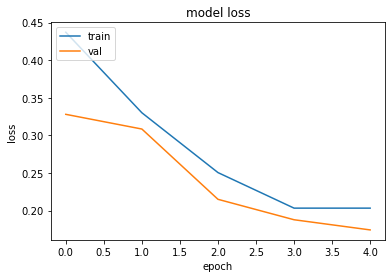

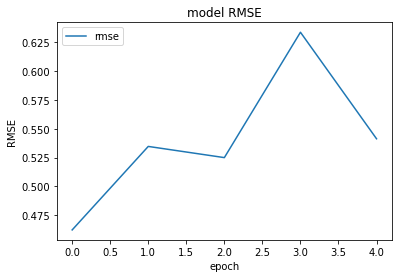

Epoch 1/5
613/613 [==============================] - 234s 375ms/step - loss: 0.3406 - val_loss: 0.2487 - val_rmse: 0.8724
Epoch 2/5
613/613 [==============================] - 226s 368ms/step - loss: 0.1945 - val_loss: 0.1781 - val_rmse: 0.9495
Epoch 3/5
613/613 [==============================] - 228s 372ms/step - loss: 0.1499 - val_loss: 0.1571 - val_rmse: 0.8548
Epoch 4/5
613/613 [==============================] - 227s 370ms/step - loss: 0.1304 - val_loss: 0.1303 - val_rmse: 0.7836
Epoch 5/5
613/613 [==============================] - 227s 370ms/step - loss: 0.1199 - val_loss: 0.1258 - val_rmse: 0.7279


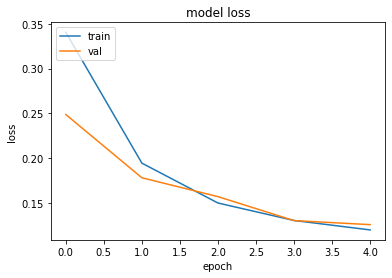

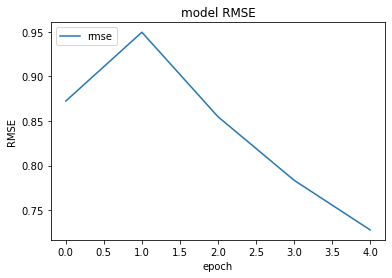

Epoch 1/5
613/613 [==============================] - 234s 375ms/step - loss: 0.3864 - val_loss: 0.2784 - val_rmse: 1.0771
Epoch 2/5
613/613 [==============================] - 227s 370ms/step - loss: 0.2126 - val_loss: 0.1701 - val_rmse: 1.1121
Epoch 3/5
566/613 [==========================>...] - ETA: 12s - loss: 0.1437

KeyboardInterrupt: 

In [53]:
for lr in lrs:
    model = train_model(lr=lr, verbose = True)


# Test the model performance on instances

In [214]:
model = train_model(lr=0.0001, epochs = 10)

Epoch 1/10
613/613 [==============================] - 230s 368ms/step - loss: 0.3358 - val_loss: 0.2279 - val_rmse: 0.7358
Epoch 2/10
613/613 [==============================] - 225s 368ms/step - loss: 0.1900 - val_loss: 0.1748 - val_rmse: 0.8495
Epoch 3/10
613/613 [==============================] - 226s 369ms/step - loss: 0.1538 - val_loss: 0.1408 - val_rmse: 0.7973
Epoch 4/10
613/613 [==============================] - 228s 371ms/step - loss: 0.1318 - val_loss: 0.1399 - val_rmse: 0.9231
Epoch 5/10
613/613 [==============================] - 228s 371ms/step - loss: 0.1173 - val_loss: 0.1172 - val_rmse: 0.8550
Epoch 6/10
613/613 [==============================] - 228s 372ms/step - loss: 0.1130 - val_loss: 0.1201 - val_rmse: 0.8614
Epoch 7/10
613/613 [==============================] - 228s 373ms/step - loss: 0.1069 - val_loss: 0.1127 - val_rmse: 0.8285
Epoch 8/10
613/613 [==============================] - 228s 372ms/step - loss: 0.1061 - val_loss: 0.1194 - val_rmse: 0.9064
Epoch 9/10
613/6

In [215]:
from tensorflow.keras import models
model.compute_output_shape(input_shape= [(None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)])                        

(TensorShape([None]), TensorShape([None]))

In [216]:
model.save('models/siamese_model')

INFO:tensorflow:Assets written to: models/siamese_model/assets


In [79]:
model = models.load_model('models/siamese_model')

In [ ]:
sample = next(iter(val_dl))

In [83]:
docked_sample = valid.iloc[0]
docked_sample.docked

'1K22_MEL'

In [92]:
docked_image = preprocess_image(docked_sample.img_docked)

In [160]:
templates = valid[valid.docked == docked_sample.docked]
templates = templates.reset_index()
templates = templates.sort_values(by=['rmsd'], ignore_index=True)
templates

,index,Unnamed: 0,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,...,mcs_docked_NumRotatableBonds,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,is_valid,img_temp,img_docked
0,1122,4764,1O0D_163,1K22_MEL,0.852,P00734,Cn1c(CNC(=O)c2cccn2C(=O)[C@@H](CC2CCCCC2)NCC(=...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]:[#6]:[#6]:[#6]-[#6]-[#7]...,33,...,10,0.339506,0.418301,-0.160169,1,1.395062,1.183007,True,1O0D_163.png,1K22_MEL.png
1,291,816,1C1V_BAB,1K22_MEL,1.457,P00734,NC(=[NH2+])c1ccc2nc(Cc3[nH]c4cc(C(N)=[NH2+])cc...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#7]-[#6]-[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7]:,...",25,...,4,0.102273,0.108571,0.376380,1,-0.977273,-1.914286,True,1C1V_BAB.png,1K22_MEL.png
2,3011,14164,3SI4_B04,1K22_MEL,1.485,P00734,C[n+]1ccccc1CNC(=O)[C@@H]1CCCN1C(=O)[C@H](N)Cc...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#6]:,-[#6]:[#6]:[#6]:[#6]-[#6]-[#7]-[#6](=[#8...",27,...,8,0.248447,0.340000,0.395415,1,0.484472,0.400000,True,3SI4_B04.png,1K22_MEL.png
3,3168,14957,1SL3_170,1K22_MEL,1.944,P00734,O=C(Cn1c(Cl)cnc(NCC(F)(F)c2cccc[n+]2[O-])c1=O)...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#6]1:[#6]:[#6]:[#6](:[#6]:[#6]:1)-[#6]-[#7]-[...,37,...,8,0.093023,0.129808,0.664748,1,-1.069767,-1.701923,True,1SL3_170.png,1K22_MEL.png
4,1746,7972,4UFG_D6J,1K22_MEL,3.020,P00734,CC[C@@H](C(=O)NCc1ccc(C(=N)N)cc1)N(C)C(=O)[C@@...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,39,...,8,0.229167,0.356322,1.105257,3,0.291667,0.563218,True,4UFG_D6J.png,1K22_MEL.png
5,3038,14302,2ZFP_19U,1K22_MEL,3.068,P00734,CC[C@@H](N)C(=O)N1CCC[C@H]1C(=O)NCc1cccc(Cl)c1,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#6]-[#6]-[#6](-[#7])-[#6](=[#8])-[#7](-[#6])-...,22,...,7,0.294964,0.440000,1.121026,3,0.949640,1.400000,True,2ZFP_19U.png,1K22_MEL.png
6,1129,4802,2ZGB_21U,1K22_MEL,3.170,P00734,CC(C)C[C@@H](N)C(=O)N1CCC[C@H]1C(=O)NCc1cccc(C...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#6]-[#6]-[#6]-[#6](-[#7])-[#6](=[#8])-[#7](-[...,24,...,7,0.282759,0.453125,1.153732,3,0.827586,1.531250,True,2ZGB_21U.png,1K22_MEL.png
7,2464,11573,1C1W_BAH,1K22_MEL,3.931,P00734,NC(=[NH2+])c1ccc2nc(C(O)(O)c3nc4ccc(C(N)=[NH2+...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#7]-[#6]-[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7]:,...",27,...,4,0.100000,0.112360,1.368894,3,-1.000000,-1.876404,True,1C1W_BAH.png,1K22_MEL.png
8,3026,14245,2C8W_C7M,1K22_MEL,4.330,P00734,COc1ccc(S(=O)(=O)NC[C@@H](O)[C@H](Cc2ccccc2)[N...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,"[#6](-[#7])-[#6]:,-[#6]:,-[#6]:,-[#6](-,:[#6])...",37,...,2,0.087963,0.169154,1.465568,3,-1.120370,-1.308458,True,2C8W_C7M.png,1K22_MEL.png
9,0,0,1YPJ_UIB,1K22_MEL,4.643,P00734,CC[C@@H]1[C@@H]2[C@H](C(=O)N1Cc1ccc3c(c1)OCO3)...,N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...,[#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...,33,...,7,0.165775,0.289941,1.535361,3,-0.342246,-0.100592,True,1YPJ_UIB.png,1K22_MEL.png


In [151]:
template_image = preprocess_image(templates.iloc[0].img_temp)

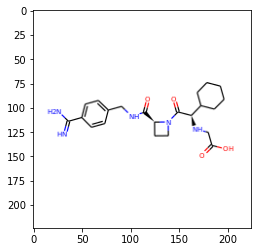

In [102]:
plt.imshow(docked_image)

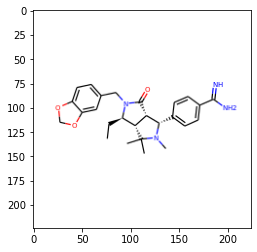

In [103]:
plt.imshow(template_image)

In [209]:
rmse = metrics.CosineSimilarity()

In [115]:
template_image = tf.reshape(template_image, (1,224,224,3))

In [118]:
docked_image = tf.reshape(docked_image, (1,224,224,3))

In [148]:
template_embedding, docked_embedding = (
    embedding(resnet.preprocess_input(template_image)),
    embedding(resnet.preprocess_input(docked_image)),
)

In [149]:
rmse_positive = rmse(template_embedding, docked_embedding)
rmse_positive.numpy(), templates.iloc[0].log_RMSD

(0.095809005, 1.53536070903778)

In [145]:
type(rmse_positive.numpy())

numpy.float32

In [210]:
def get_rmse(row):
    docked_image = preprocess_image(row.img_docked)
    template_image = preprocess_image(row.img_temp)
    template_image = tf.reshape(template_image, (1,224,224,3))
    docked_image = tf.reshape(docked_image, (1,224,224,3))
    template_embedding, docked_embedding = (
        embedding(resnet.preprocess_input(template_image)),
        embedding(resnet.preprocess_input(docked_image)),
    )
    rmse_positive = rmse(template_embedding, docked_embedding)
    return rmse_positive.numpy()

In [211]:
rmses = {}
for i, r in templates.iterrows(): 
    rm = get_rmse(r)
    rmses[i] = rm
rmses

{0: 0.99421334,
 1: 0.9937172,
 2: 0.99156684,
 3: 0.99209166,
 4: 0.991601,
 5: 0.9902351,
 6: 0.989606,
 7: 0.99065304,
 8: 0.98962253,
 9: 0.9899658,
 10: 0.9902416,
 11: 0.9903514,
 12: 0.9906636,
 13: 0.99078894,
 14: 0.9911796,
 15: 0.9912274,
 16: 0.9915618,
 17: 0.99183697,
 18: 0.9908405}

In [212]:
rmses_sorted = sorted(rmses, key=rmses.get)
rmses_sorted

[6, 8, 9, 5, 10, 11, 7, 12, 13, 18, 14, 15, 16, 2, 4, 17, 3, 1, 0]

In [153]:
rmses.index(min(rmses))

4

In [154]:
templates.iloc[4].template

'3P17_99P'

In [138]:
for i, r in templates.iterrows():
    print(r)

Unnamed: 0                                                                        0
template                                                                   1YPJ_UIB
docked                                                                     1K22_MEL
rmsd                                                                          4.643
uniprot_id                                                                   P00734
smiles_template                   CC[C@@H]1[C@@H]2[C@H](C(=O)N1Cc1ccc3c(c1)OCO3)...
smiles_docked                     N=C(N)c1ccc(CNC(=O)[C@@H]2CCN2C(=O)[C@H](NCC(=...
mcs_smartsString                  [#7]=[#6](-[#7])-[#6]1:[#6]:[#6]:[#6](:[#6]:[#...
template_HeavyAtomCount                                                          33
template_NHOHCount                                                                3
template_NOCount                                                                  7
template_RingCount                                                          